<a href="https://colab.research.google.com/github/DBhugwandas/HotelCancel/blob/master/Predict_Hotel_Cancellations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(10)

In [5]:
!pip install optuna
import optuna

In [6]:
df = pd.read_csv('hotel_bookings.csv')

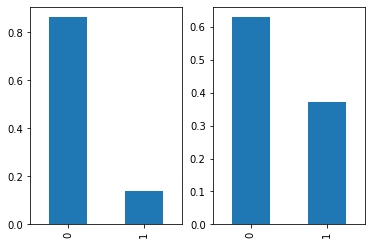

In [7]:
#Handling Missing Values
df.isnull().sum()

#%of values missing
df.isnull().sum()/df.shape[0]

#Does company have an impact on the cancelled indicatior (target)
f1 = plt.subplot(1, 2, 1)
(df[df['country'].isnull()].is_canceled.value_counts()/(421+67)).plot.bar()
f2 = plt.subplot(1, 2, 2)
(df[df['country'].notnull()].is_canceled.value_counts()/118902).plot.bar()
plt.show()

In [8]:
#It does appear that cancellation rates are much lower where country variable is missing
#Encode Country variable that is missing to its own category
df['missing_country'] = np.where(df.country.isnull() == True,1,0)

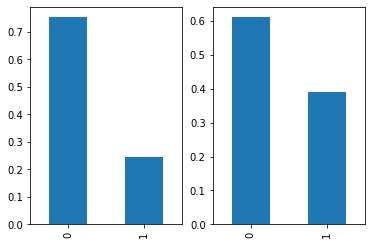

In [9]:
#Agent Missing Field
f1 = plt.subplot(1, 2, 1)
(df[df['agent'].isnull()].is_canceled.value_counts()/(df[df['agent'].isnull()].is_canceled.value_counts().sum())).plot.bar()
f2 = plt.subplot(1, 2, 2)
(df[df['agent'].notnull()].is_canceled.value_counts()/df[df['agent'].notnull()].is_canceled.value_counts().sum()).plot.bar()
plt.show()

#Seems like lower cancellations where agent is missing -- Lets encode that into it's own category
df['missing_agent'] = np.where(df.agent.isnull() == True,1,0)
#Replacing with -1
df.agent.fillna(-1,inplace=True)


In [10]:
#Encoding missing category to it's own variable and deleting the existing column
df['company_present'] = np.where(df.company.isnull()==True,1,0)
df.drop('company',axis=1,inplace=True)


In [11]:
ones = df.country.value_counts() < 10
ones[ones==True].sum()

#In the country variable, many countries with only a small number of bookings.
#Therefore to encode these we can employ top N encoding
#Encoding the top 95% of countries and the rest classified as other

country_count = df.country.value_counts().sort_values(ascending=False).cumsum()/df.country.value_counts().sum()
top_country = country_count[country_count <= 0.97]
top_country.count()

#So now we have 29 countries, from the intial list of 170 countries
#We can encode them as follows

for cols in top_country.index:
    df["country_"+cols] = np.where(df.country == cols,1,0)
    
df.drop('country',axis=1,inplace=True)

In [12]:
#Missing children variable - Fill with median
df.children.fillna(df.children.median(),inplace=True)

In [13]:
#Encoding Categorical Variables
Type = (df.dtypes == 'O')
cols = Type[Type==True].index

for col in cols:
    print("--------------relationship to canceled------------------")
    print(df.groupby(col).is_canceled.mean().sort_values(ascending=False))
    print(col,"--------------counts----------------")
    print(df[col].value_counts())
    print("---------------------------------------")
    print("Number of Unique Categories:",len(df[col].unique()))
    print("---------------------------------------")
    print('\n')

--------------relationship to canceled------------------
hotel
City Hotel      0.417270
Resort Hotel    0.277634
Name: is_canceled, dtype: float64
hotel --------------counts----------------
City Hotel      79330
Resort Hotel    40060
Name: hotel, dtype: int64
---------------------------------------
Number of Unique Categories: 2
---------------------------------------


--------------relationship to canceled------------------
arrival_date_month
June         0.414572
April        0.407972
May          0.396658
September    0.391702
October      0.380466
August       0.377531
July         0.374536
December     0.349705
February     0.334160
March        0.321523
November     0.312334
January      0.304773
Name: is_canceled, dtype: float64
arrival_date_month --------------counts----------------
August       13877
July         12661
May          11791
October      11160
April        11089
June         10939
September    10508
March         9794
February      8068
November      6794
Decembe

In [14]:
df.meal.unique()

array(['BB', 'FB', 'HB', 'SC', 'Undefined'], dtype=object)

### Variable to Encode

Hotel               -----> One-hot encoding

arrival_date_month  ----> Label ordinal encoding (months does seem to play a role in cancellations)

meal                ----> few categories therefore one hot encoding

market_segment       ---> does seem to influence cancellations, therefore mean encoding

distribution_channel ---> mean encoding as does influence cancellation rates

customer_type ----> mean encoding as does influence cancellation rates

reserved_room_type   ----> No major differences except for rooms with small number of bookings, use one-hot

assigned_room_type   ----> No major differences except for rooms with small number of bookings, use one-hot

deposit_type         ----> one-hot as small number of categories

reservation_status    ----> remove as contains info about cancellations



In [15]:
#Performing one-hot encoding
cols = ['hotel','meal','reserved_room_type','assigned_room_type','deposit_type']
df1 = pd.get_dummies(df,columns=cols,prefix=cols,drop_first=True)
df1.drop(['reservation_status','reservation_status_date'],axis=1,inplace=True)
df1.columns

Index(['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'market_segment', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'booking_changes', 'agent', 'days_in_waiting_list', 'customer_type',
       'adr', 'required_car_parking_spaces', 'total_of_special_requests',
       'missing_country', 'missing_agent', 'company_present', 'country_PRT',
       'country_GBR', 'country_FRA', 'country_ESP', 'country_DEU',
       'country_ITA', 'country_IRL', 'country_BEL', 'country_BRA',
       'country_NLD', 'country_USA', 'country_CHE', 'country_CN',
       'country_AUT', 'country_SWE', 'country_CHN', 'country_POL',
       'country_ISR', 'country_RUS', 'country_NOR', 'country_ROU',
       'country_FIN', 'country_DNK', 'country_AUS', 'country_AGO',
   

In [16]:
#Label Encoding

#Arrival Date
encoding = df1.groupby('arrival_date_month').is_canceled.mean().sort_values(ascending=False).rank().to_dict()
df1['arrival_date_month'] = df1['arrival_date_month'].map(encoding)

#Mean Encoding
def Mean_Encode(df,cols):
    for col in cols:
        encoding = df.groupby(col).is_canceled.mean().sort_values(ascending=False).to_dict() 
        df[col] = df[col].map(encoding)
    return df

df1 = Mean_Encode(df1,['market_segment','distribution_channel','customer_type'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



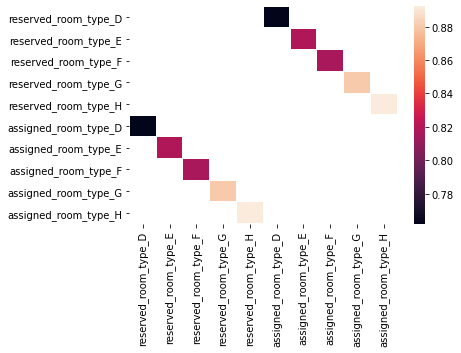

In [17]:
# Correlations between features
import seaborn as sns
cols = list(df1.corr()[(df1.corr() >= 0.7) & (df1.corr() != 1)].sum().where(lambda x: x != 0).dropna().index)
sns.heatmap(df1.corr()[(df1.corr() >= 0.7) & (df1.corr() != 1)].loc[cols,cols],linewidths=.10)

#As we might expect the reserved room type and assigned room type variables are highly correlated
#We can remove one of them --- we remove assigned becuase it may be a variable that we dont know beforehand

In [18]:
df1.drop(cols[-5:len(cols)],axis=1,inplace=True)

In [19]:
#Feature Selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [20]:
X = df1.drop('is_canceled',axis=1)
y = df1['is_canceled']

#Test Train Split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,shuffle=True)

#Feature Importance
model = RandomForestClassifier(n_estimators = 100,verbose=1,n_jobs=-1)
best = model.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.4s finished


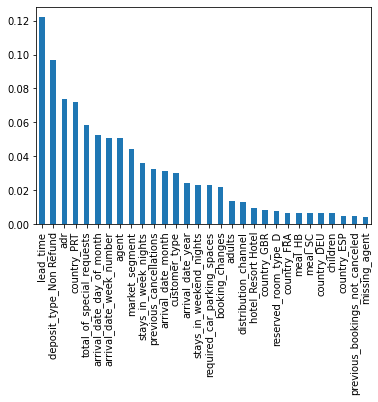

In [21]:
pd.Series(dict(zip(list(X.columns),list(best.feature_importances_)))).sort_values(ascending=False).head(30).plot.bar()
cols_keep = list(pd.Series(dict(zip(list(X.columns),list(best.feature_importances_)))).sort_values(ascending=False).head(30).index)

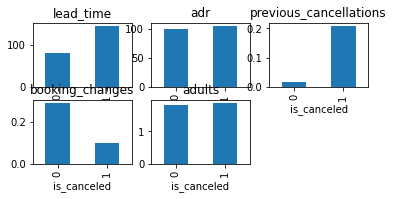

In [22]:
#Lead time is the most significant variable. Lets explore it

cols = ['lead_time','adr','previous_cancellations','booking_changes','adults']
i = 1
fig = plt.figure()
for col in cols:
    ax = fig.add_subplot(3,3,i)
    df1.groupby('is_canceled')[col].mean().plot.bar(title=col)
    i += 1

plt.show()


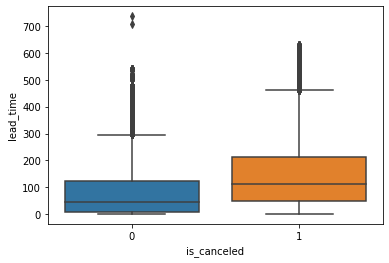

In [23]:
#Important features relationship
sns.boxplot(y=df.lead_time,x=df.is_canceled,orient='v')

In [24]:
# As we can see from the above, people who cancelled their booking generally had a longer lead time than those that did not.
print(cols_keep)
#Selecting the top 30 features
df2 = df1[cols_keep]
X = df1.drop('is_canceled',axis=1)
y = df1['is_canceled']

#Test Train Split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,shuffle=True)

['lead_time', 'deposit_type_Non Refund', 'adr', 'country_PRT', 'total_of_special_requests', 'arrival_date_day_of_month', 'arrival_date_week_number', 'agent', 'market_segment', 'stays_in_week_nights', 'previous_cancellations', 'arrival_date_month', 'customer_type', 'arrival_date_year', 'stays_in_weekend_nights', 'required_car_parking_spaces', 'booking_changes', 'adults', 'distribution_channel', 'hotel_Resort Hotel', 'country_GBR', 'reserved_room_type_D', 'country_FRA', 'meal_HB', 'meal_SC', 'country_DEU', 'children', 'country_ESP', 'previous_bookings_not_canceled', 'missing_agent']


In [25]:
###### Creating a Model --- Inital Model #######
import warnings
warnings.filterwarnings('ignore')
#### First simple model --- Logistc Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

model = LogisticRegression(penalty='l2',n_jobs = -1,verbose=1,)

best = cross_val_score(estimator = model,X=X_train,y=y_train,verbose=0,n_jobs=-1,cv=10)
print('mean_score is:',best.mean())

mean_score is: 0.7540470734327718


In [26]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
cross_val_score

<function sklearn.model_selection._validation.cross_val_score>

In [27]:
model = LogisticRegression(penalty='l2',n_jobs = 1,verbose=0,).fit(X_train,y_train)
print("Training Accuracy:",model.score)
print(classification_report(y_test,model.predict(X_test)))
print(confusion_matrix(y_test,model.predict(X_test)))

Training Accuracy: <bound method ClassifierMixin.score of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)>
              precision    recall  f1-score   support

           0       0.76      0.89      0.82     22613
           1       0.73      0.53      0.62     13204

    accuracy                           0.76     35817
   macro avg       0.75      0.71      0.72     35817
weighted avg       0.75      0.76      0.75     35817

[[20042  2571]
 [ 6189  7015]]


In [28]:
#As we can see from the above, we are doing poorly on the positve classes.

###### Second Model --- RandomForest Classifier

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 100, n_jobs=-1, max_depth = 100, verbose=1,).fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.6s finished


In [29]:
print('mean_accuracy:',cross_val_score(estimator = model,X=X_train,y=y_train,verbose=0,n_jobs=-1,cv=10).mean())
print(classification_report(y_test,model.predict(X_test)))
print(confusion_matrix(y_test,model.predict(X_test)))

mean_accuracy: 0.8905508642605039


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.8s finished


              precision    recall  f1-score   support

           0       0.90      0.94      0.92     22613
           1       0.89      0.82      0.85     13204

    accuracy                           0.89     35817
   macro avg       0.89      0.88      0.88     35817
weighted avg       0.89      0.89      0.89     35817



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.9s finished


[[21224  1389]
 [ 2385 10819]]


In [32]:
# We are getting quite good results from the Random Forest Model
# We can further improve the model by using hyperparameter optimization (using optuna)

import optuna

#Defining the sample space and objective function
def objective(trial):
    
    #Define the sample space
    n_estimators = trial.suggest_int('n_estimators',50,500,10)
    criterion = trial.suggest_categorical('criterion',['gini', 'entropy'])
    max_depth = trial.suggest_float('max_depth',2,200,log=True)
    min_samples_split = trial.suggest_float('min_samples_split',0,0.9)
    #min_samples_leaf = trial.suggest_float('min_samples_leaf',0.05,0.8)
    max_features = trial.suggest_categorical('max_features',['auto', 'log2'])
    
    #Define the model
    model = RandomForestClassifier(n_estimators = n_estimators,
                                  criterion = criterion,
                                   max_depth = max_depth,
                                   min_samples_split = min_samples_split,
                                   #min_samples_leaf = min_samples_leaf,
                                   max_features = max_features,
                                  n_jobs = -1)
    
    
    #Obtaining Cross Validation Score ---- mean score
    score = cross_val_score(model,X_train,y_train,n_jobs=-1,cv=10).mean()
    
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials = 100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2020-08-15 10:11:15,212] Trial 0 finished with value: 0.7531739121483645 and parameters: {'n_estimators': 90, 'criterion': 'entropy', 'max_depth': 2.578564540221802, 'min_samples_split': 0.33311709175851556, 'max_features': 'auto'}. Best is trial 0 with value: 0.7531739121483645.
[I 2020-08-15 10:11:38,157] Trial 1 finished with value: 0.6288274910166828 and parameters: {'n_estimators': 270, 'criterion': 'gini', 'max_depth': 60.67737746352723, 'min_samples_split': 0.6349670579755522, 'max_features': 'log2'}. Best is trial 0 with value: 0.7531739121483645.
[I 2020-08-15 10:12:11,068] Trial 2 finished with value: 0.6288274910166828 and parameters: {'n_estimators': 390, 'criterion': 'gini', 'max_depth': 6.037245790075705, 'min_samples_split': 0.7371769412550425, 'max_features': 'log2'}. Best is trial 0 with value: 0.7531739121483645.
[I 2020-08-15 10:13:41,114] Trial 3 finished with value: 0.7704522401176066 and parameters: {'n_estimators': 330, 'criterion': 'entropy', 'max_depth': 6.1

Accuracy: 0.8852859601631582
Best hyperparameters: {'n_estimators': 290, 'criterion': 'entropy', 'max_depth': 175.9719831596934, 'min_samples_split': 0.00018730392427335858, 'max_features': 'auto'}


In [34]:
best_params = {'n_estimators': 290, 'criterion': 'entropy', 'max_depth': 175.9719831596934, 'min_samples_split': 0.00018730392427335858, 'max_features': 'auto'}

model = RandomForestClassifier(n_estimators = 290, criterion = 'entropy', max_depth = 175.9719831596934, min_samples_split = 0.00018730392427335858, max_features = 'auto',n_jobs=-1).fit(X_train,y_train)
print(classification_report(y_test,model.predict(X_test)))
print(confusion_matrix(y_test,model.predict(X_test)))


              precision    recall  f1-score   support

           0       0.89      0.94      0.91     22613
           1       0.88      0.80      0.84     13204

    accuracy                           0.89     35817
   macro avg       0.89      0.87      0.88     35817
weighted avg       0.89      0.89      0.89     35817

[[21193  1420]
 [ 2627 10577]]


In [ ]:
# We are getting an overall accuray of 89% on the test set and 88.5% on the cross validation set.
# Therefore this model works quite well and generalizes well --- Low bias and variance.